In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from vnstock import *

from Tools.function import *
from Tools.operators import *
from Tools.technical import *

from Fundamental.fndl import *

##### VN30

In [2]:
close = pd.read_csv("Data/close.csv", index_col="TradingDate", parse_dates=True)
high = pd.read_csv("Data/high.csv", index_col="TradingDate", parse_dates=True)
low = pd.read_csv("Data/low.csv", index_col="TradingDate", parse_dates=True)
open = pd.read_csv("Data/open.csv", index_col="TradingDate", parse_dates=True)
volume = pd.read_csv("Data/volume.csv", index_col="TradingDate", parse_dates=True)
returns = close.pct_change()

In [ ]:
def group_means(x,group):
    df = pd.DataFrame()
    g = group.values
    v = x.values
    va = []
    for i in range(len(g)):
        df.index = g[i]
        df["v"] = v[i]
        df.v=df.groupby(df.index).agg(np.mean)
        va.append(df["v"].to_list())
    df = pd.DataFrame(va)
    df.index = x.index

In [111]:
group = sign(returns)

In [178]:
df = pd.DataFrame()
g = group.values
v = close.values
va = []
for i in range(len(g)):
    df.index = g[i]
    df["v"] = v[i]
    df.v=df.groupby(df.index).rank()
    va.append(df["v"].to_list())
df = pd.DataFrame(va)
df.index = close.index

In [179]:
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
TradingDate,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,2.0,NaN,NaN,4.0,5.0,4.0,3.0,NaN,NaN,1.0,...,NaN,NaN,2.0,NaN,NaN,2.0,NaN,6.0,NaN,NaN
2013-01-04,3.0,NaN,NaN,11.0,6.0,5.0,10.0,NaN,NaN,1.0,...,NaN,NaN,7.0,NaN,NaN,2.0,NaN,9.0,NaN,NaN
2013-01-07,1.0,NaN,NaN,8.0,4.0,1.0,4.0,NaN,NaN,1.0,...,NaN,NaN,5.0,NaN,NaN,7.0,NaN,3.0,NaN,NaN
2013-01-08,1.0,NaN,NaN,11.0,5.0,4.0,10.0,NaN,NaN,1.0,...,NaN,NaN,6.0,NaN,NaN,8.0,NaN,9.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,12.0,19.0,5.0,16.0,3.0,1.0,21.0,4.0,7.0,9.5,...,13.0,11.0,20.0,15.0,9.5,17.0,7.0,18.0,5.0,2.0
2023-02-14,6.0,11.0,11.0,9.0,9.0,10.0,16.0,2.0,4.0,5.0,...,7.0,6.0,14.0,10.0,4.0,12.0,15.0,13.0,3.0,8.0
2023-02-15,11.0,21.0,17.0,18.0,14.0,20.0,24.0,3.0,5.0,9.0,...,12.0,10.0,22.5,3.0,8.0,1.0,4.0,19.0,4.0,13.0


In [181]:
close

,ACB,BCM,BID,BVH,CTG,FPT,GAS,GVR,HDB,HPG,...,TCB,TPB,VCB,VHM,VIB,VIC,VJC,VNM,VPB,VRE
TradingDate,,,,,,,,,,,,,,,,,,,,,
2013-01-02,4130.0,NaN,NaN,31526.0,11250.0,6573.0,24194.0,NaN,NaN,1481.0,...,NaN,NaN,11697.0,NaN,NaN,17014.0,NaN,23659.0,NaN,NaN
2013-01-03,4059.0,NaN,NaN,33090.0,11144.0,6482.0,24194.0,NaN,NaN,1495.0,...,NaN,NaN,11991.0,NaN,NaN,17014.0,NaN,23523.0,NaN,NaN
2013-01-04,4083.0,NaN,NaN,34733.0,11197.0,6573.0,24753.0,NaN,NaN,1544.0,...,NaN,NaN,12286.0,NaN,NaN,17014.0,NaN,23931.0,NaN,NaN
2013-01-07,4083.0,NaN,NaN,36454.0,11250.0,6537.0,24753.0,NaN,NaN,1621.0,...,NaN,NaN,12622.0,NaN,NaN,17759.0,NaN,23931.0,NaN,NaN
2013-01-08,4083.0,NaN,NaN,38253.0,11357.0,6862.0,25311.0,NaN,NaN,1692.0,...,NaN,NaN,13254.0,NaN,NaN,17971.0,NaN,25018.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,23900.0,83800.0,44400.0,48500.0,29150.0,80700.0,105900.0,14000.0,18050.0,20200.0,...,26600.0,23000.0,93500.0,44400.0,20200.0,53400.0,103100.0,75300.0,17000.0,28500.0
2023-02-14,23850.0,84500.0,43400.0,49100.0,28700.0,80800.0,105600.0,14150.0,17650.0,20600.0,...,26850.0,23500.0,92500.0,42750.0,20500.0,52900.0,102800.0,74700.0,16700.0,28000.0
2023-02-15,24550.0,84900.0,44000.0,49400.0,28900.0,81600.0,107100.0,14500.0,17800.0,20800.0,...,27400.0,23800.0,93000.0,42500.0,20700.0,52900.0,102700.0,76000.0,17200.0,28350.0


[-1.0,
 nan,
 nan,
 1.0,
 -1.0,
 -1.0,
 0.0,
 nan,
 nan,
 1.0,
 -1.0,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 nan,
 -1.0,
 1.0,
 nan,
 nan,
 1.0,
 nan,
 nan,
 0.0,
 nan,
 -1.0,
 nan,
 nan]

### Fundamental

In [9]:
a= Stimulate(rank(fndl("asset")/fndl("inventory")))

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness        Margin
0  0.079687  0.553987  0.000021  0.442321  3.832309e+06
Overall of neutralize
    Return    Sharpe  Turnover   Fitness         Margin
0  0.04559  0.436548  0.000081  0.263639  563783.834667


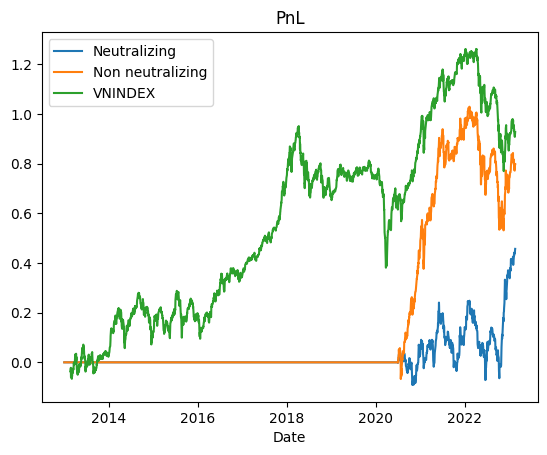

In [10]:
a.plot_pnl()
a.overall()

### Prob weight model

Overall of non neutralize
     Return   Sharpe  Turnover   Fitness      Margin
0  0.169819  1.45689  0.964032  0.611469  176.155048
Overall of neutralize
     Return    Sharpe  Turnover   Fitness    Margin
0  0.281644  1.863437  2.181574  0.669546  129.1015


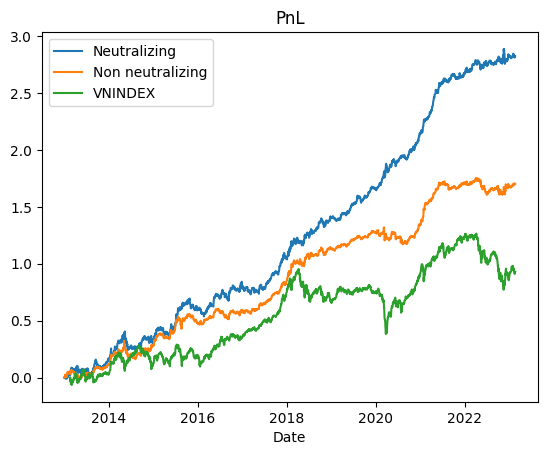

In [14]:
prob = prob_weights(volume,5)
kq = Stimulate(prob)
kq.plot_pnl()
kq.overall()

### Markowitz model

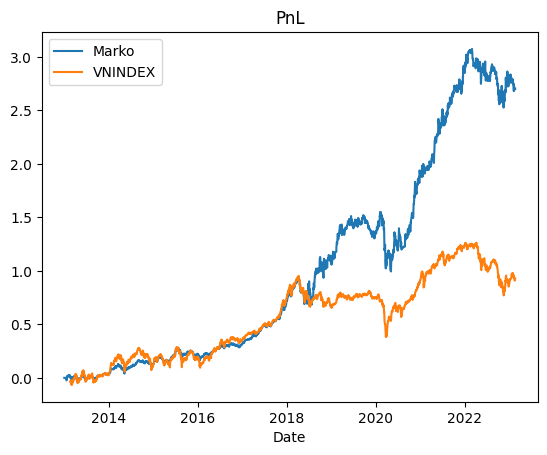

In [12]:
mark = marko_weights(close,lag=10)
a = Simresult(mark,returns=close.pct_change())
a.plot_pnl("Marko")

plot_vnindex()

### volum/adv20

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.291403  1.424841  0.389687  1.232126  747.786486
Overall of neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.368011  2.270369  1.403737  1.162476  262.165246


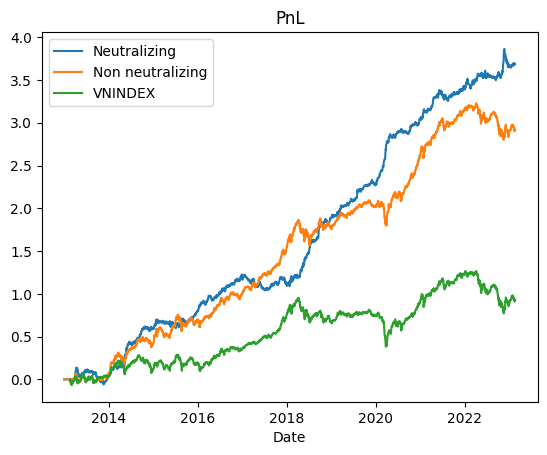

In [3]:
alpha1 =volume/ts_mean(ts_decay_linear(volume,30),20)
kq1 = Stimulate(alpha1)
kq1.plot_pnl()
kq1.overall()

##### MAE

Overall of non neutralize
     Return    Sharpe  Turnover  Fitness      Margin
0  0.286801  1.393488  0.418816  1.15314  684.790231
Overall of neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.436995  2.785714  1.572834  1.468362  277.838986


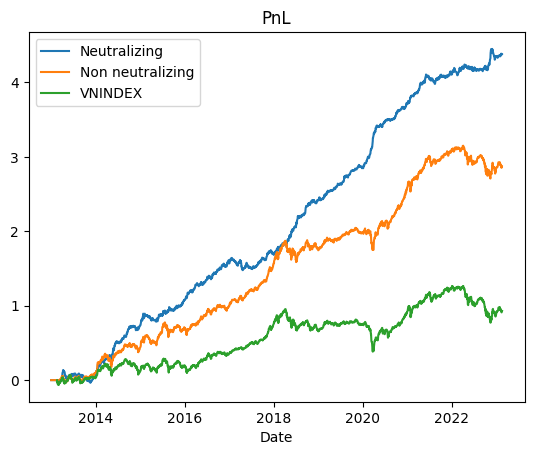

In [8]:
alpha2 = rank(mae(alpha1))
kq2 = Stimulate(alpha2)
kq2.plot_pnl()
kq2.overall()

##### MACD hist

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness     Margin
0  0.291101  1.425176  0.401759  1.213131  724.56623
Overall of neutralize
     Return   Sharpe  Turnover   Fitness      Margin
0  0.451233  2.88869  1.508431  1.579932  299.140265


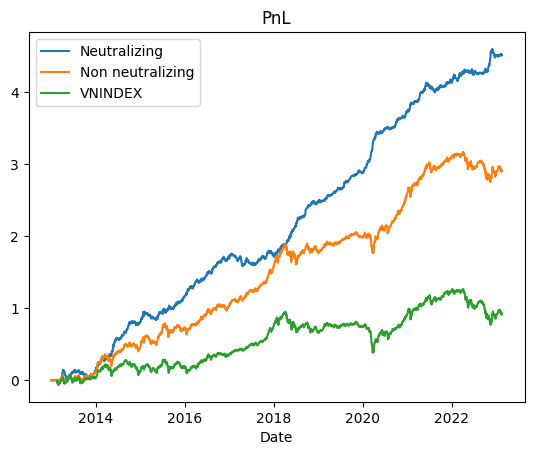

In [4]:
alpha3 = rank(macd_his(alpha1))
kq3 = Stimulate(alpha3)
kq3.plot_pnl()
kq3.overall()

##### Save weight

In [11]:
kq3.get_weights()

Neutralization
BVH    0.128889
NVL    0.120000
VHM    0.111111
VIB    0.102222
POW    0.093333
STB    0.084444
VIC    0.075556
BID    0.066667
HDB    0.057778
GAS    0.048889
TPB    0.040000
VCB    0.031111
VJC    0.022222
BCM    0.013333
PDR    0.004444
CTG   -0.004444
ACB   -0.013333
VRE   -0.022222
GVR   -0.031111
PLX   -0.040000
FPT   -0.048889
MBB   -0.057778
SSI   -0.066667
HPG   -0.075556
VPB   -0.084444
MWG   -0.093333
VNM   -0.102222
MSN   -0.111111
TCB   -0.120000
SAB   -0.128889
Name: 2023-02-17 00:00:00, dtype: float64
Non-Neutralization
BVH    0.066667
NVL    0.064368
VHM    0.062069
VIB    0.059770
POW    0.057471
STB    0.055172
VIC    0.052874
BID    0.050575
HDB    0.048276
GAS    0.045977
TPB    0.043678
VCB    0.041379
VJC    0.039080
BCM    0.036782
PDR    0.034483
CTG    0.032184
ACB    0.029885
VRE    0.027586
GVR    0.025287
PLX    0.022989
FPT    0.020690
MBB    0.018391
SSI    0.016092
HPG    0.013793
VPB    0.011494
MWG    0.009195
VNM    0.006897
MSN    0.004

In [13]:
save_weights(kq3.neu,"2023-02-17")